In [1]:
import sys
sys.path.append(r'C:/Program Files (zk)/PythonFiles/AClassification/AudioClassification-Pytorch-KZhao/')

In [2]:
import os
import yaml
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from ackit.data_utils.collate_fn import collate_fn
from ackit.trainer_setting import get_model
from ackit.utils.utils import load_ckpt
from ackit.data_utils.coughvid_reader import CoughVID_Dataset
from ackit.data_utils.featurizer import Wave2Mel
from ackit.utils.plotter import calc_accuracy, plot_heatmap

### 基本参数设置

In [3]:
configs = {
    "run_save_dir": "../runs/tdnn_coughvid/",
    "model":{
        "num_class": 3,
        "input_length": 94,
        "wav_length": 48000,
        "input_dim": 512,
        "n_mels": 80,
        },
    "fit":{
        "batch_size": 64,
        "epochs" : 35,
        "start_scheduler_epoch": 6
        },
}

In [4]:
# istrain: 如果是评估环节，设为False，读取测试集，并且不创建optimizer
# isdemo: 如果只是测试一下，设为True，仅读取32条数据方便快速测试是否有bug
istrain, isdemo = True, False

configs = "../configs/tdnn_coughvid.yaml"
with open(configs) as stream:
    configs = yaml.safe_load(stream)
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
num_epoch = configs["fit"]["epochs"]
timestr = time.strftime("%Y%m%d%H%M", time.localtime())
if istrain:
    run_save_dir = configs["run_save_dir"] + timestr + f'_tdnn/'
if not isdemo:
    os.makedirs(run_save_dir, exist_ok=True)
# train_dataset = None
train_loader = None

## 极为耗时的一句，读取数据

In [ ]:
train_dataset = CoughVID_Dataset(root_path="../datasets/waveinfo_annotation.csv", configs=configs, isdemo=isdemo)

Loading:   0%|                                                                               | 0/15085 [00:00<?, ?it/s]C:/Program Files (zk)/PythonFiles/AClassification/AudioClassification-Pytorch-KZhao\ackit\data_utils\audio.py:117: UserWarning: PySoundFile failed. Trying audioread instead.
  samples, sample_rate = librosa.core.load(file)  # , dtype='float32')
C:\Users\zhaoke\miniconda3\envs\torch-0\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Loading:   0%|                                                                     | 1/15085 [00:00<3:46:20,  1.11it/s]C:/Program Files (zk)/PythonFiles/AClassification/AudioClassification-Pytorch-KZhao\ackit\data_utils\audio.py:117: UserWarning: PySoundFile failed. Trying audioread instead.
  samples, sample_rate = librosa.core.load(file)  # , dt

In [ ]:
# dataloader
train_loader = DataLoader(train_dataset, batch_size=configs["fit"]["batch_size"], shuffle=True,collate_fn=collate_fn)
# data_transform
w2m = Wave2Mel(sr=16000, n_mels=80)

In [ ]:
# model loss_function optimizer scheduler
model = get_model("tdnn", self.configs, istrain=True).to(device)
cls_loss = nn.CrossEntropyLoss().to(device)
print("All model and loss are on device:", device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=5e-5)

# train and valid

In [ ]:
history1 = []
for epoch_id in range(self.num_epoch):
    # ---------------------------
    # -----------TRAIN-----------
    # ---------------------------
    self.model.train()
    for x_idx, (x_wav, y_label, _) in enumerate(tqdm(self.train_loader, desc="Training")):
        x_mel = self.w2m(x_wav).to(self.device)
        y_label = torch.tensor(y_label, device=self.device)
        # print("shape of x_mel:", x_mel.shape)
        self.optimizer.zero_grad()
        y_pred = self.model(x=x_mel)
        # recon_loss = self.recon_loss(recon_spec, x_mel)
        pred_loss = self.cls_loss(y_pred, y_label)
        pred_loss.backward()
        self.optimizer.step()

        if x_idx > 2:
            history1.append(pred_loss.item())
        if x_idx % 60 == 0:
            print(f"Epoch[{epoch_id}], mtid pred loss:{pred_loss.item():.4f}")
    if epoch_id >= self.configs["fit"]["start_scheduler_epoch"]:
        self.scheduler.step()

    # ---------------------------
    # -----------SAVE------------
    # ---------------------------
    plt.figure(0)
    plt.plot(range(len(history1)), history1, c="green", alpha=0.7)
    plt.savefig(self.run_save_dir + f'cls_loss_iter_{epoch_id}.png')
    plt.close()
    # if epoch > 6 and epoch % 2 == 0:
    os.makedirs(self.run_save_dir + f"model_epoch_{epoch_id}/", exist_ok=True)
    tmp_model_path = "{model}model_{epoch}.pth".format(
        model=self.run_save_dir + f"model_epoch_{epoch_id}/",
        epoch=epoch_id)
    torch.save(self.model.state_dict(), tmp_model_path)
    # ---------------------------
    # -----------TEST------------
    # ---------------------------
    self.model.eval()
    heatmap_input = None
    labels = None
    for x_idx, (x_wav, y_label, _) in enumerate(tqdm(self.train_loader, desc="Test")):
        x_mel = self.w2m(x_wav).to(self.device)
        y_label = torch.tensor(y_label, device=self.device)
        y_pred = self.model(x=x_mel)
        if x_idx == 0:
            heatmap_input, labels = y_pred, y_label
        else:
            heatmap_input = torch.concat((heatmap_input, y_pred), dim=0)
            labels = torch.concat((labels, y_label), dim=0)
        if x_idx * self.configs["fit"]["batch_size"] > 800:
            break
    print("heatmap_input shape:", heatmap_input.shape)
    print("lables shape:", labels.shape)
    # if epoch > 3:
    #     self.plot_reduction(resume_path="", load_epoch=epoch, reducers=["heatmap"])
    heatmap_input = heatmap_input.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    calc_accuracy(pred_matrix=heatmap_input, label_vec=labels,
                  save_path=self.run_save_dir + f"/accuracy_epoch_{epoch_id}.png")
    plot_heatmap(pred_matrix=heatmap_input, label_vec=labels,
                 ticks=["bearing", "fan", "gearbox", "slider", "ToyCar", "ToyTrain", "valve"],
                 save_path=self.run_save_dir + f"/heatmap_epoch_{epoch_id}.png")
print("============== END TRAINING ==============")

In [ ]:
# 

Loading:   0%|                                                                               | 0/15085 [00:00<?, ?it/s]C:/Program Files (zk)/PythonFiles/AClassification/AudioClassification-Pytorch-KZhao\ackit\data_utils\audio.py:117: UserWarning: PySoundFile failed. Trying audioread instead.
  samples, sample_rate = librosa.core.load(file)  # , dtype='float32')
C:\Users\zhaoke\miniconda3\envs\torch-0\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Loading:   0%|                                                                     | 1/15085 [00:00<2:40:38,  1.57it/s]C:/Program Files (zk)/PythonFiles/AClassification/AudioClassification-Pytorch-KZhao\ackit\data_utils\audio.py:117: UserWarning: PySoundFile failed. Trying audioread instead.
  samples, sample_rate = librosa.core.load(file)  # , dt

All model and loss are on device: cuda


Training:   0%|                                                                                | 0/236 [00:00<?, ?it/s]C:\Users\zhaoke\AppData\Local\Temp\ipykernel_27108\2719852831.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_label = torch.tensor(y_label, device=self.device)
Training:   1%|▉                                                                       | 3/236 [00:02<02:58,  1.31it/s]

Epoch[0], mtid pred loss:1.1983


Training:  27%|██████████████████▉                                                    | 63/236 [00:05<00:08, 19.90it/s]

Epoch[0], mtid pred loss:0.9952


Training:  52%|████████████████████████████████████▍                                 | 123/236 [00:09<00:08, 13.83it/s]

Epoch[0], mtid pred loss:1.0963


Training:  78%|██████████████████████████████████████████████████████▎               | 183/236 [00:14<00:03, 15.59it/s]

Epoch[0], mtid pred loss:0.9548


Test:   0%|                                                                                    | 0/236 [00:00<?, ?it/s]C:\Users\zhaoke\AppData\Local\Temp\ipykernel_27108\2719852831.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_label = torch.tensor(y_label, device=self.device)
Test:   6%|████▏                                                                      | 13/236 [00:00<00:11, 19.48it/s]


heatmap_input shape: torch.Size([896, 3])
lables shape: torch.Size([896])
(896, 3)
acc: 0.6071428571428571
precision: ['0.8014', '0.3485', '0.1584']
recall: ['0.6717', '0.4693', '0.2857']


TypeError: expected str, bytes or os.PathLike object, not NoneType

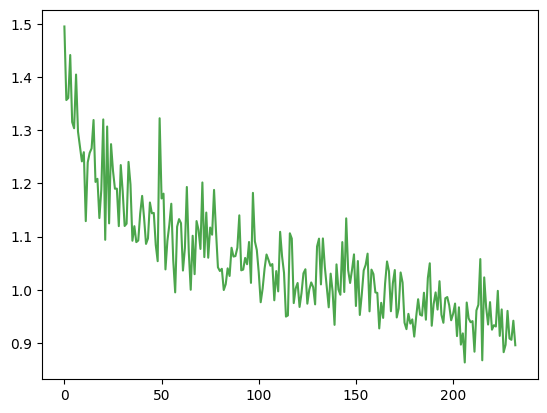

In [9]:
trainer = TrainerTDNN(istrain=True, isdemo=False)
trainer.train()